# Load and display downloaded point cloud

In [ ]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob
import matplotlib.pyplot as plt
import numpy as np
from os import path
import os

In [ ]:
root_path = os.getenv('WIN_GITHUB')

In [ ]:
%pwd

'/mnt/c/Users/GGPC/Documents/GitHub/wind-simulation/nbs'

In [ ]:
print(root_path)

/mnt/c/Users/GGPC/Documents/GitHub/


In [ ]:
c_path_north = os.path.join(*[root_path,'wind-simulation/data/raw/','lds-auckland-north-lidar-1m-dem-2016-2018-GTiff'])
c_path_south = os.path.join(*[root_path,'wind-simulation/data/raw/','lds-auckland-south-lidar-1m-dsm-2016-2017-GTiff'])
#ds-auckland-south-lidar-1m-dsm-2016-2017-GTiff

In [ ]:
print(c_path_north)

/mnt/c/Users/GGPC/Documents/GitHub/wind-simulation/data/raw/lds-auckland-north-lidar-1m-dem-2016-2018-GTiff


In [ ]:
raster_files = glob.glob(f"{c_path_north}/*.tif") + glob.glob(f"{c_path_south}/*.tif")

In [ ]:
rasters = []

In [ ]:
# Open the rasters
for file in raster_files:
    src = rasterio.open(file)
    rasters.append(src)

In [ ]:
# Merge rasters
mosaic, out_trans = merge(rasters)

In [ ]:
mosaic[0,20,20]

-9999.0

/tmp/ipykernel_2192/1990142664.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("BrBG").copy()
  cmap.set_bad(color='white')


<matplotlib.image.AxesImage>

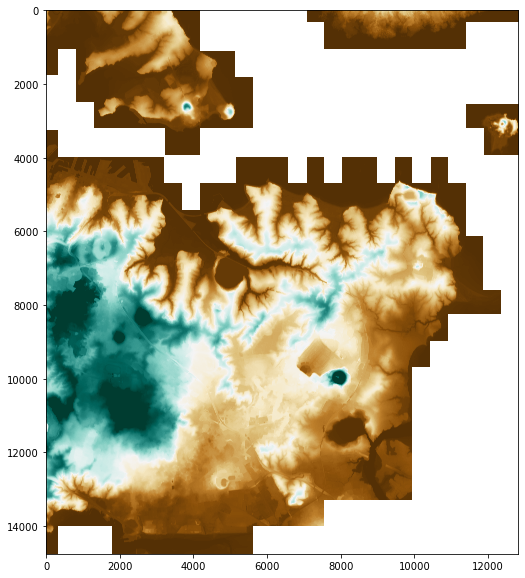

In [ ]:
 #Set the no-data value (replace with the actual no-data value for your data)
no_data_value = -9999

# Mask the no-data values
mosaic_masked = np.ma.masked_where(mosaic[0] == no_data_value, mosaic[0])

# Choose a colormap
cmap = plt.cm.BrBG
# Set the 'bad' data (masked data) color to 'white' or any other color
cmap.set_bad(color='white')

# Plot the masked array with the colormap
plt.figure(figsize=(10, 10))
plt.imshow(mosaic_masked, cmap=cmap)

# Optionally, set the color range to the 2nd and 98th percentiles to enhance contrast
vmin, vmax = np.percentile(mosaic_masked.compressed(), (2, 98))
plt.imshow(mosaic_masked, cmap=cmap, vmin=vmin, vmax=vmax)